# 1: Imports & Setup
Blaablabla


Loading EUA data...
Fetching Natural Gas data...
Fetching Gold data...
Fetching Bitcoin data...

Total records collected: 2857
After cleaning: 254 records

Calculating technical indicators...

Data saved to commodities_trading.db

EXPLORATORY DATA ANALYSIS

1. SUMMARY STATISTICS BY COMMODITY:
        Price                                                             Vol  \
        count       mean       std    min    25%    50%      75%    max count   
Symbol                                                                          
EUA     254.0  74.806969  5.502961  60.94  70.99  73.52  79.2125  88.54   0.0   

             ...         Daily_Return                                         \
       mean  ... 75% max        count      mean      std       min       25%   
Symbol       ...                                                               
EUA     NaN  ... NaN NaN        253.0  0.072165  1.57878 -4.262753 -0.881913   

                                     
             50%      

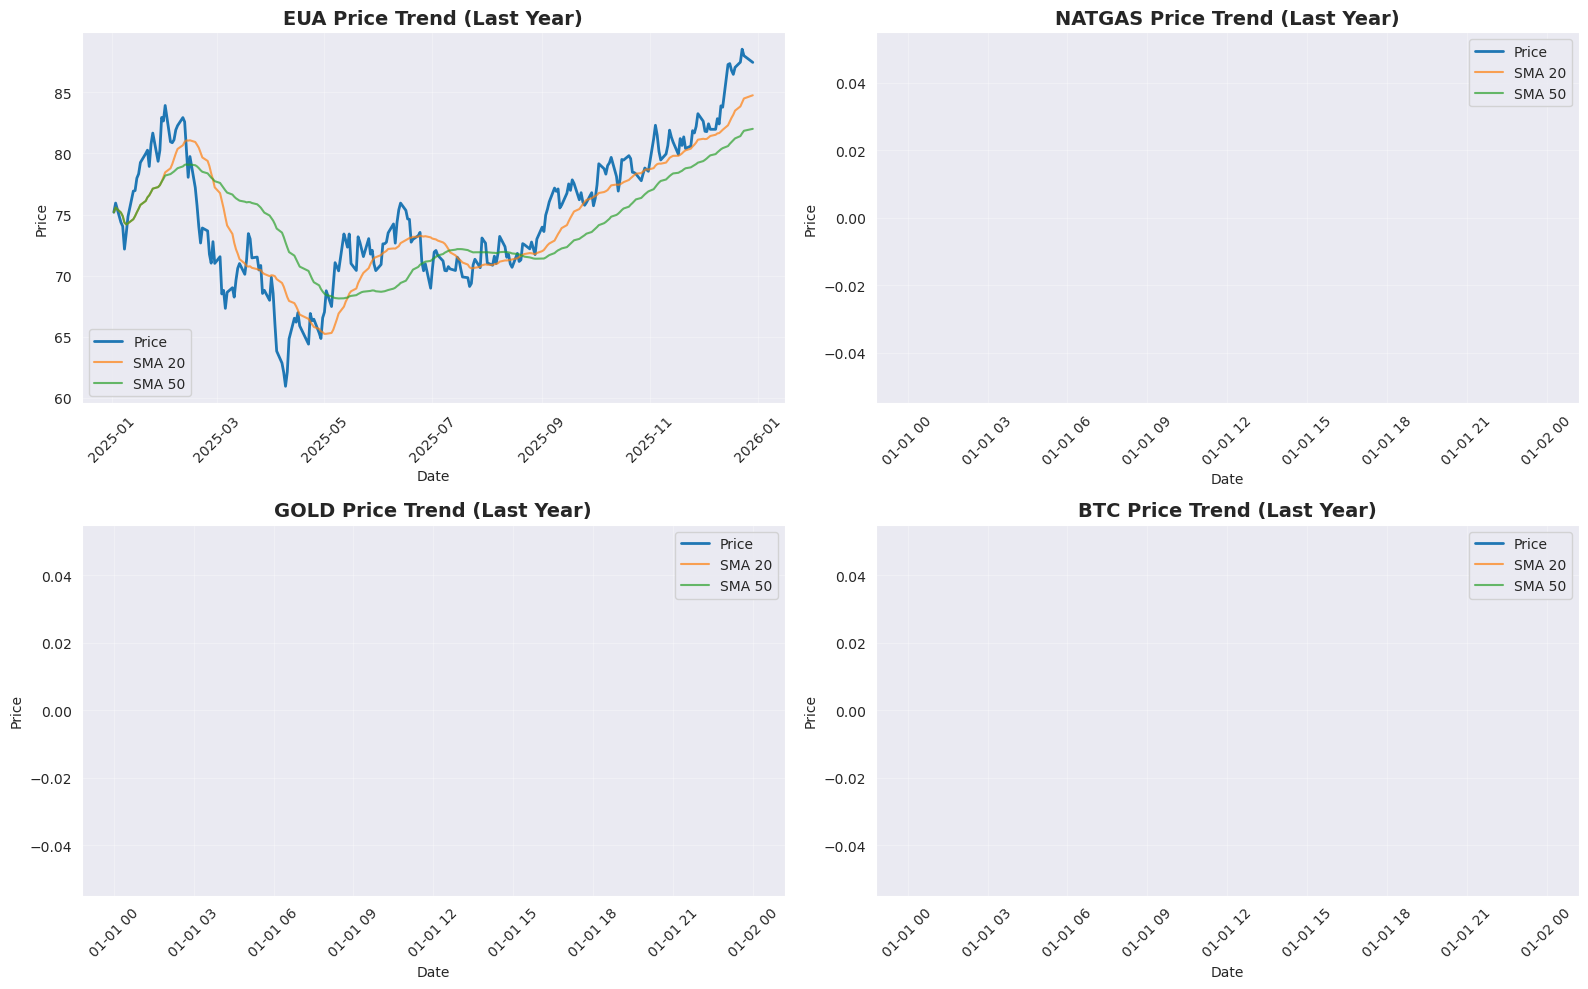

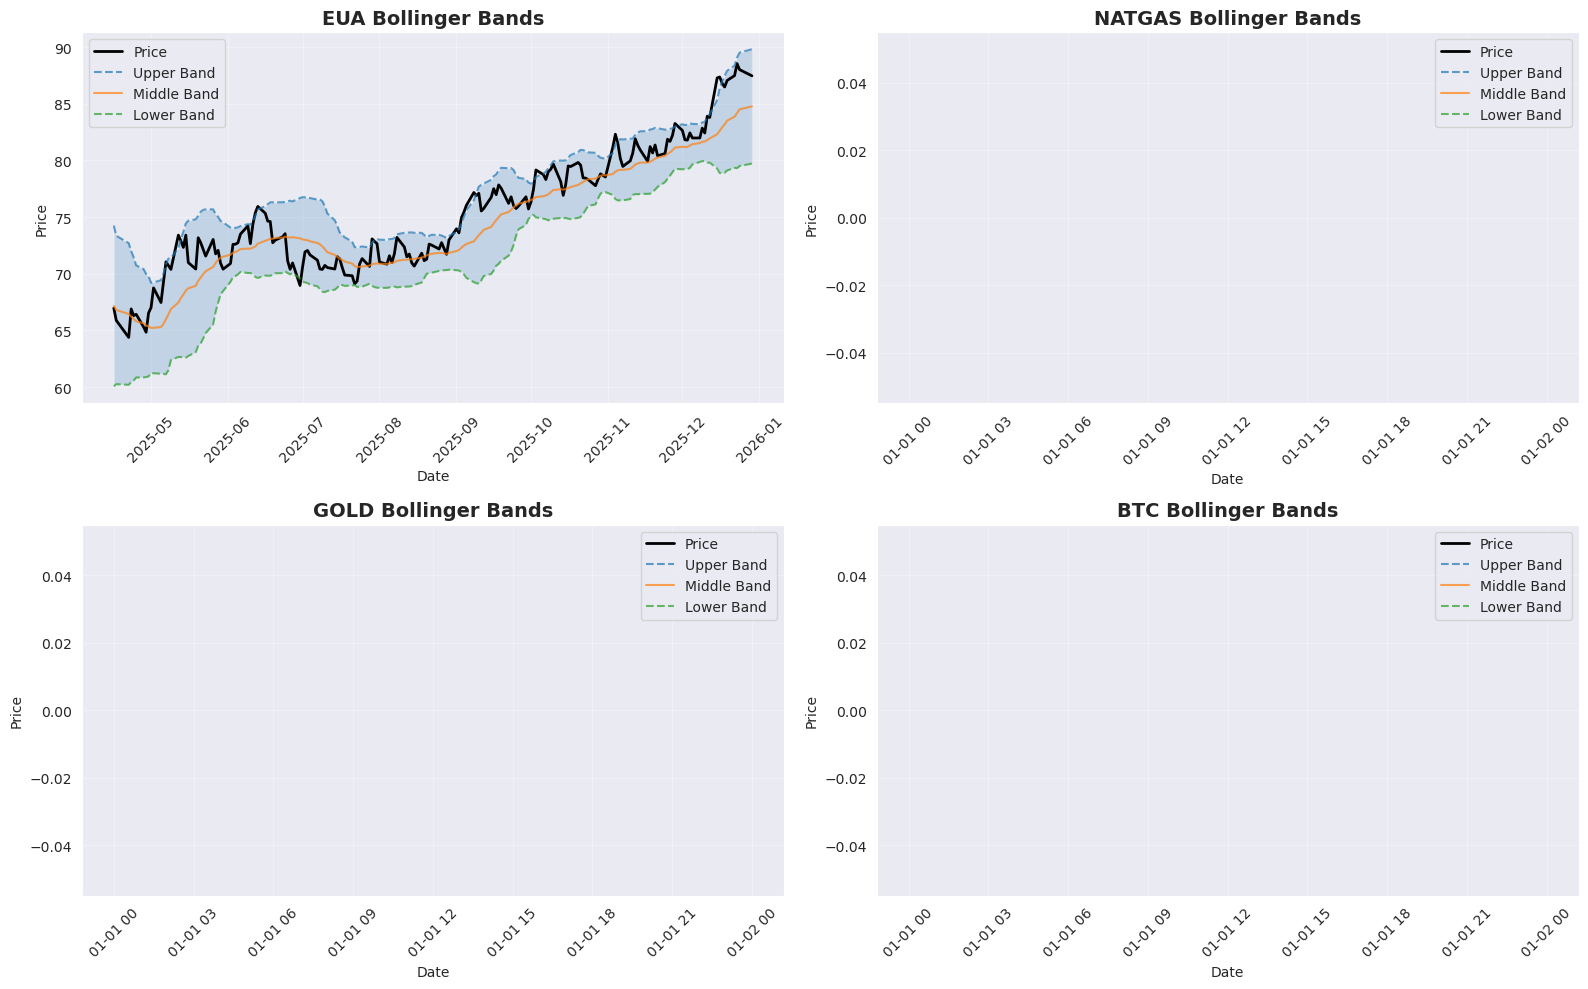

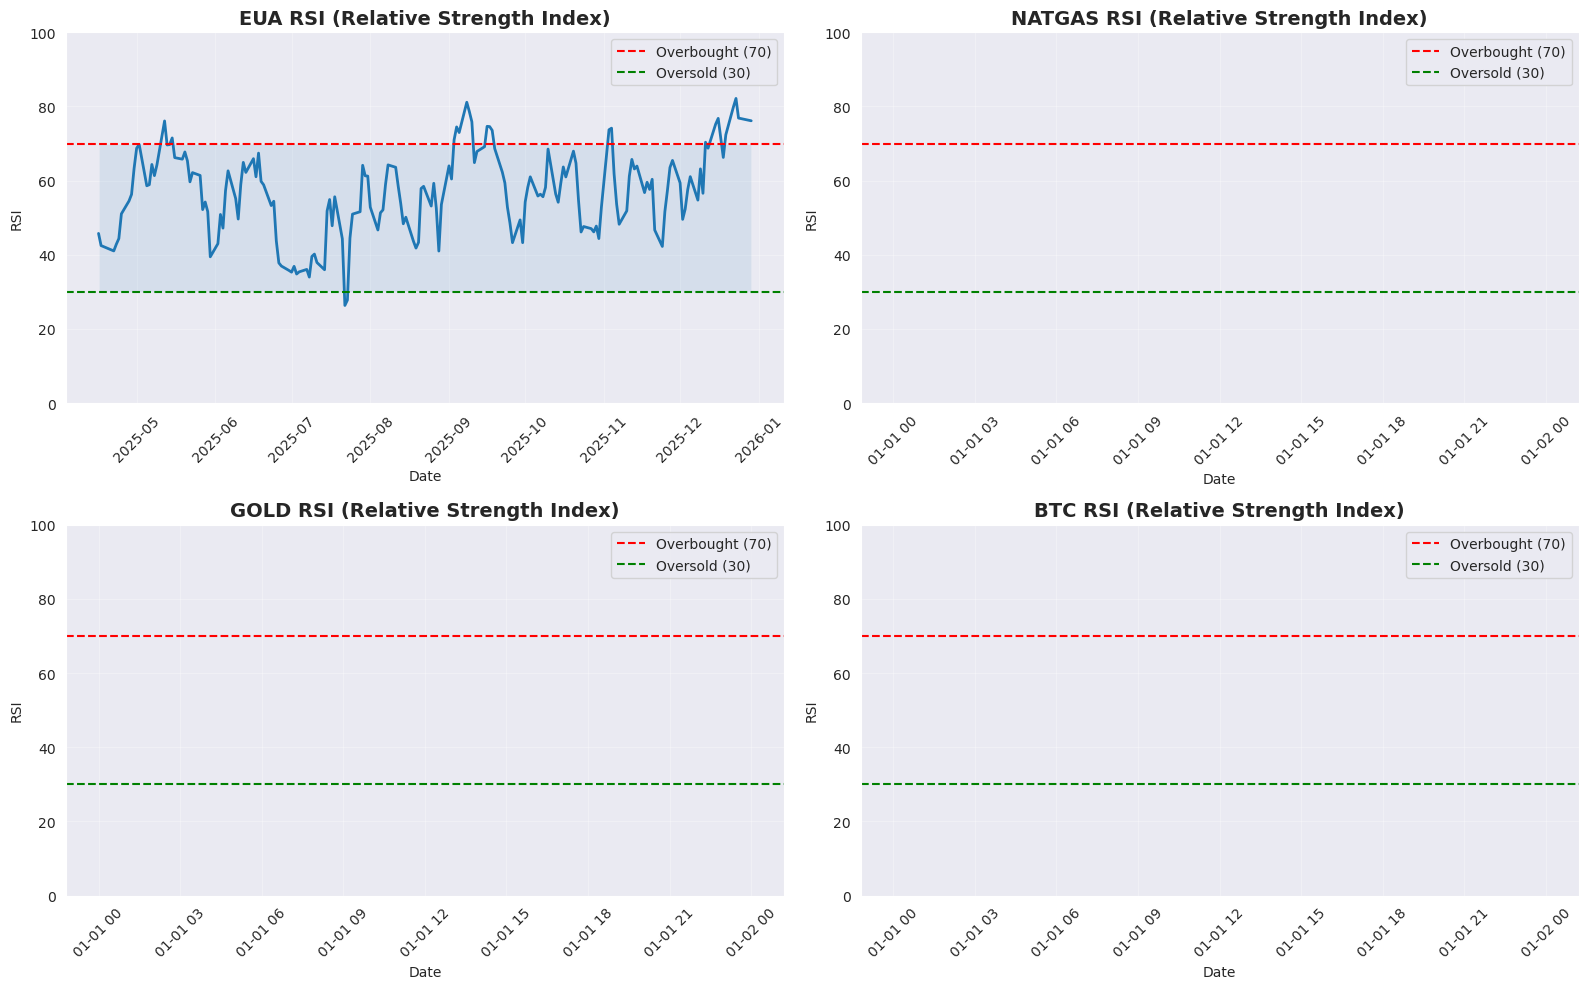

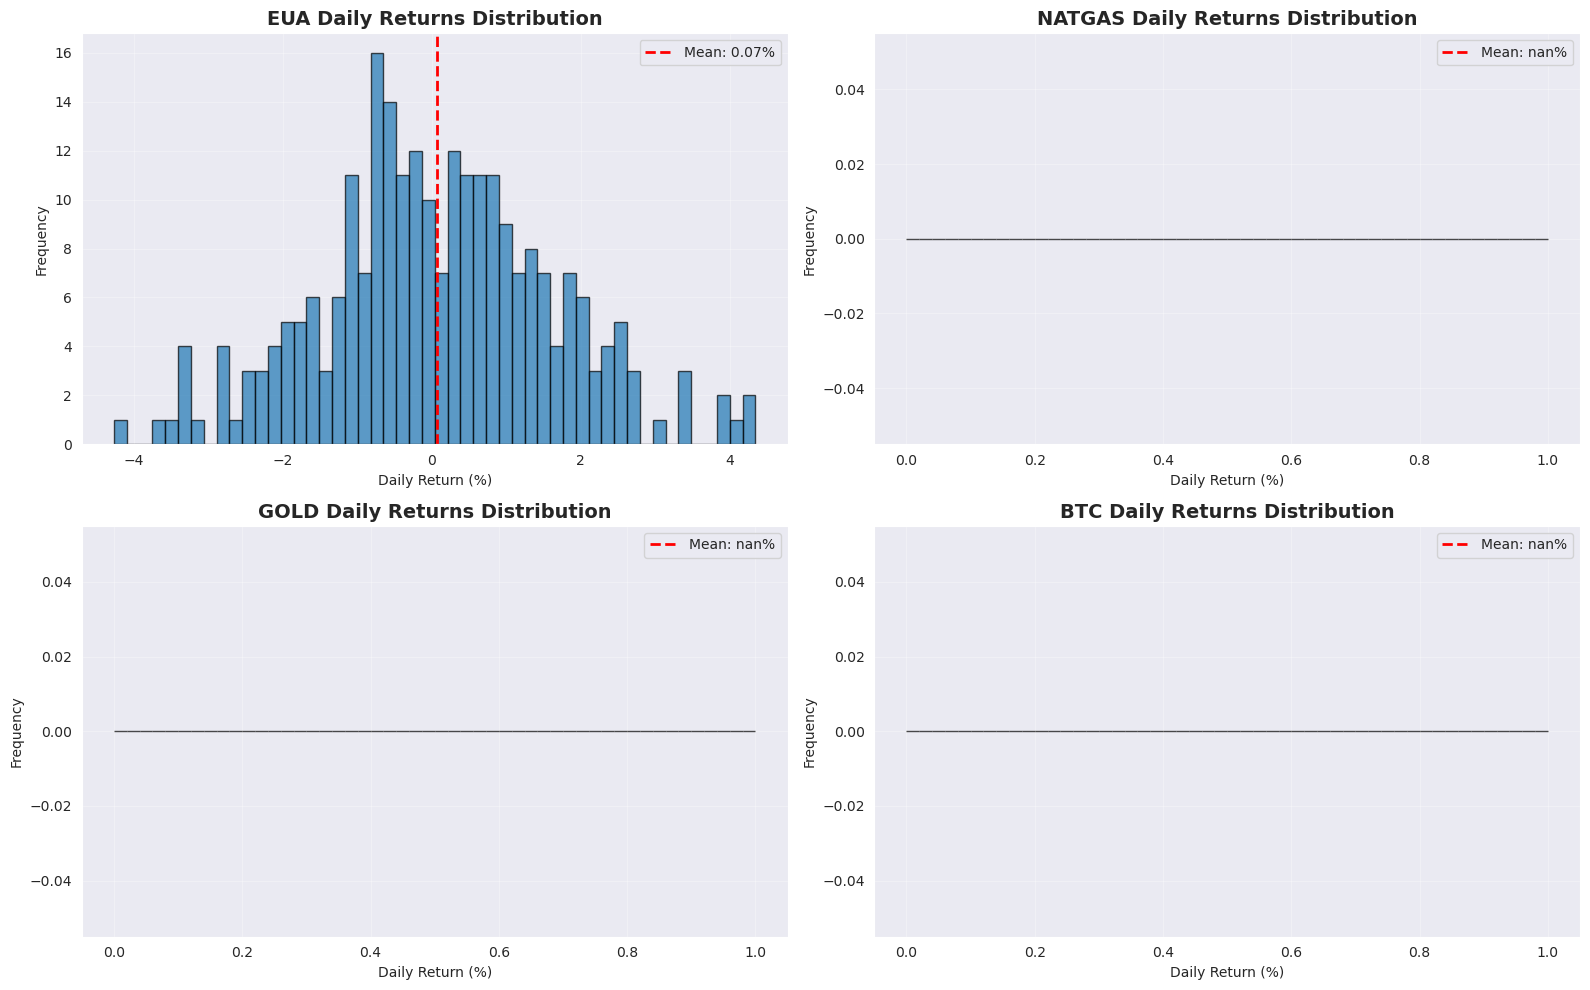

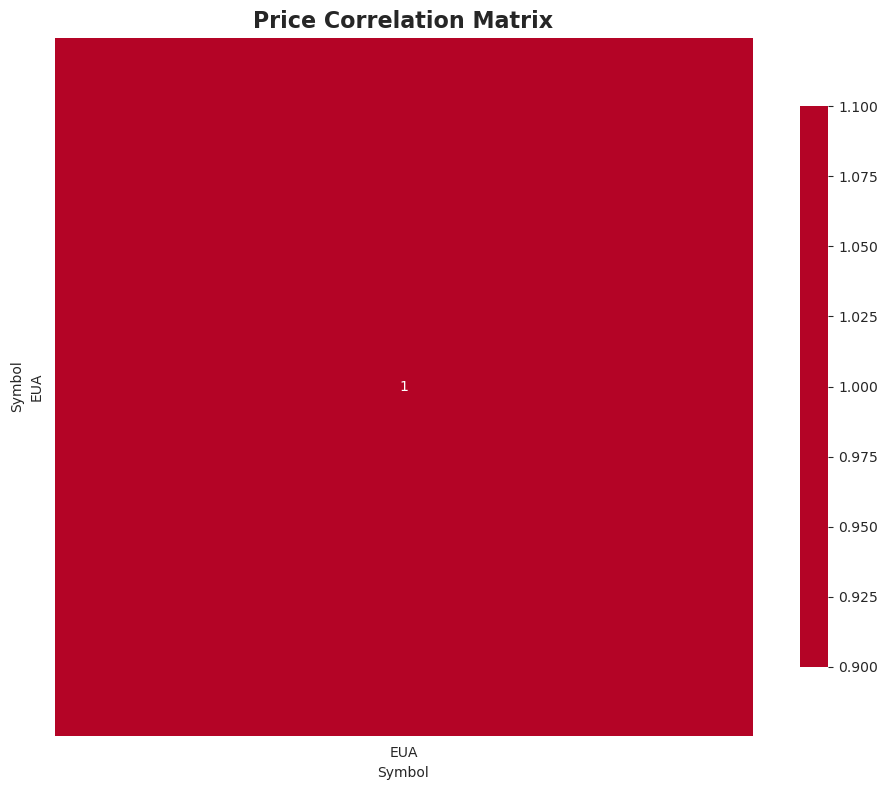

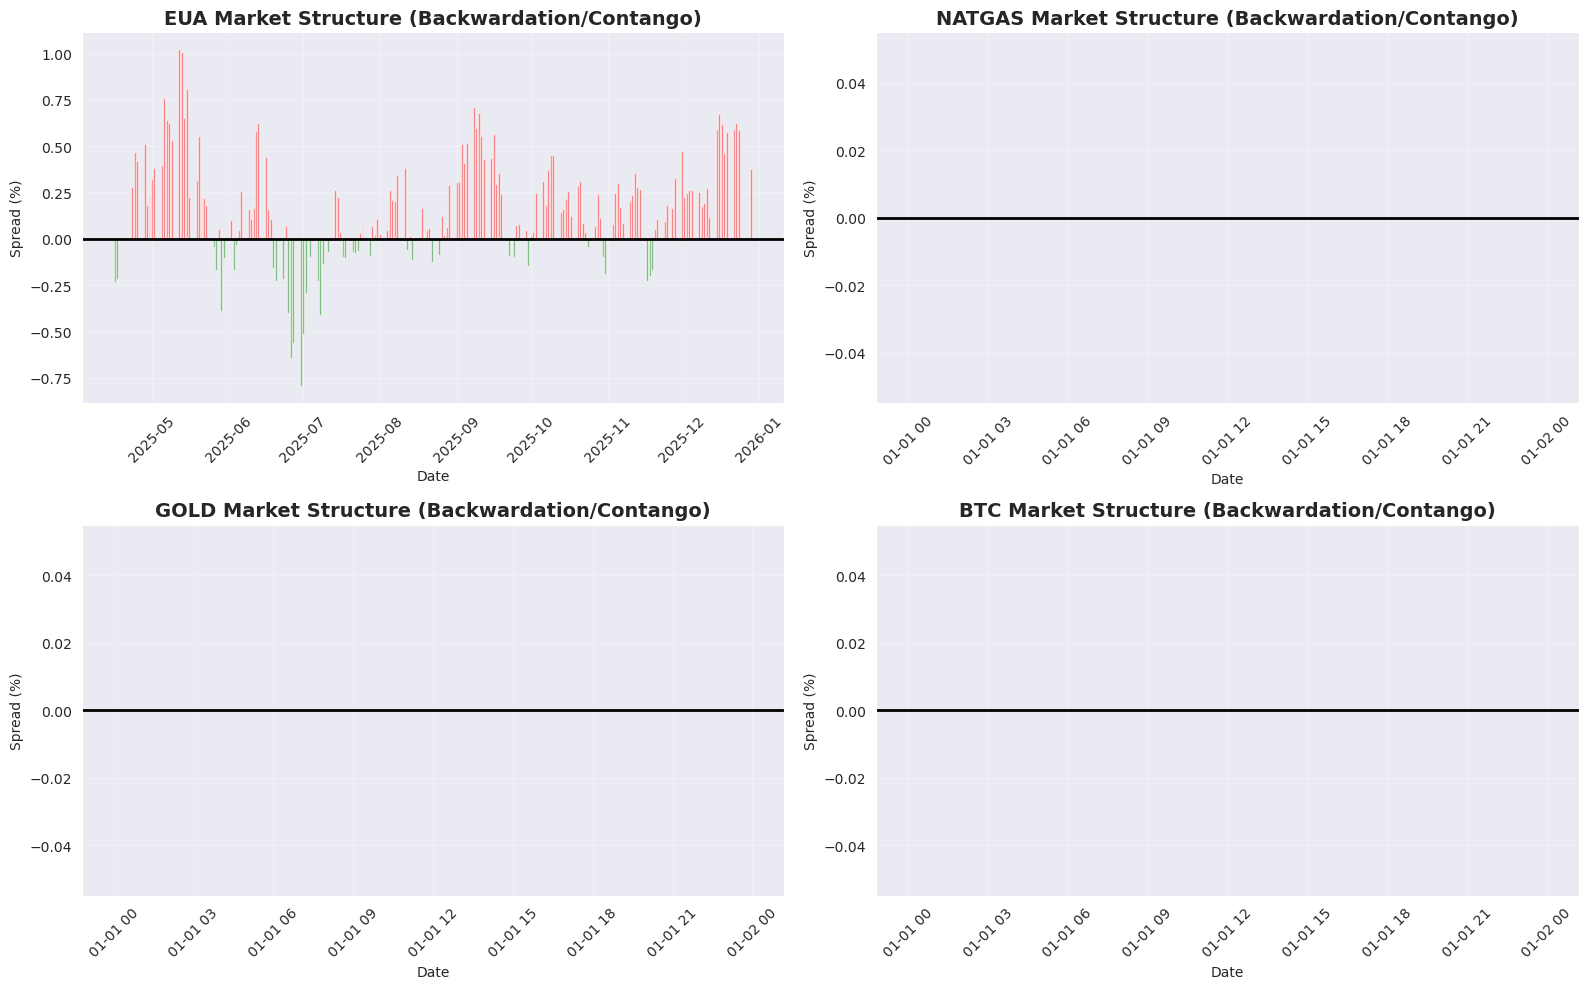

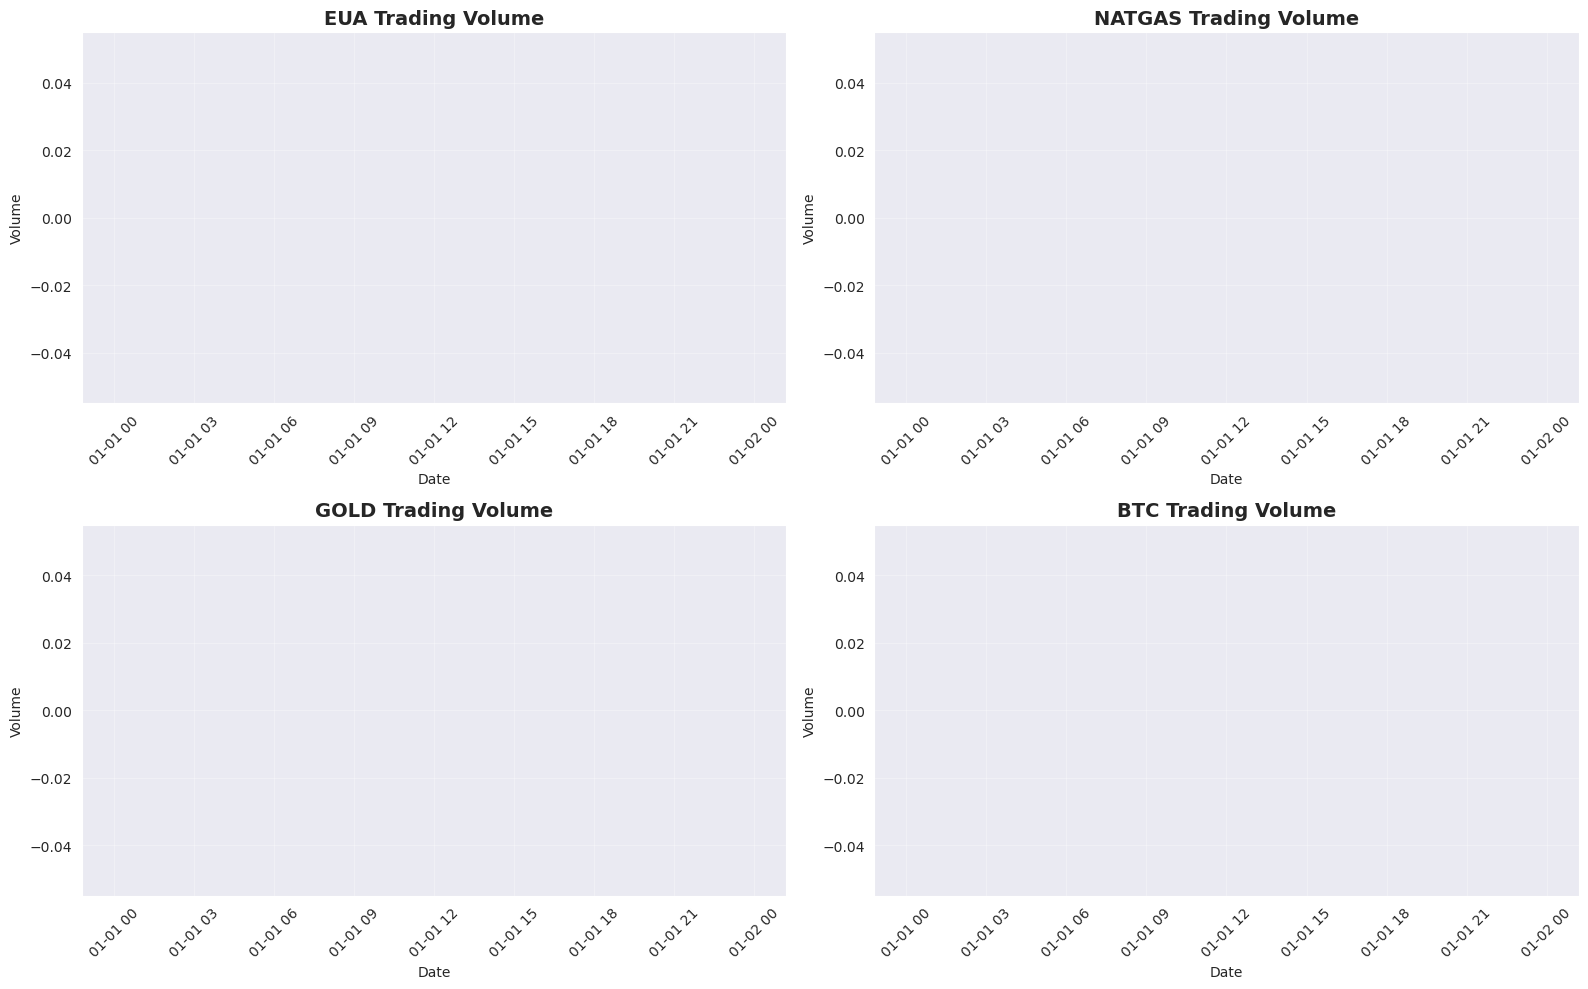

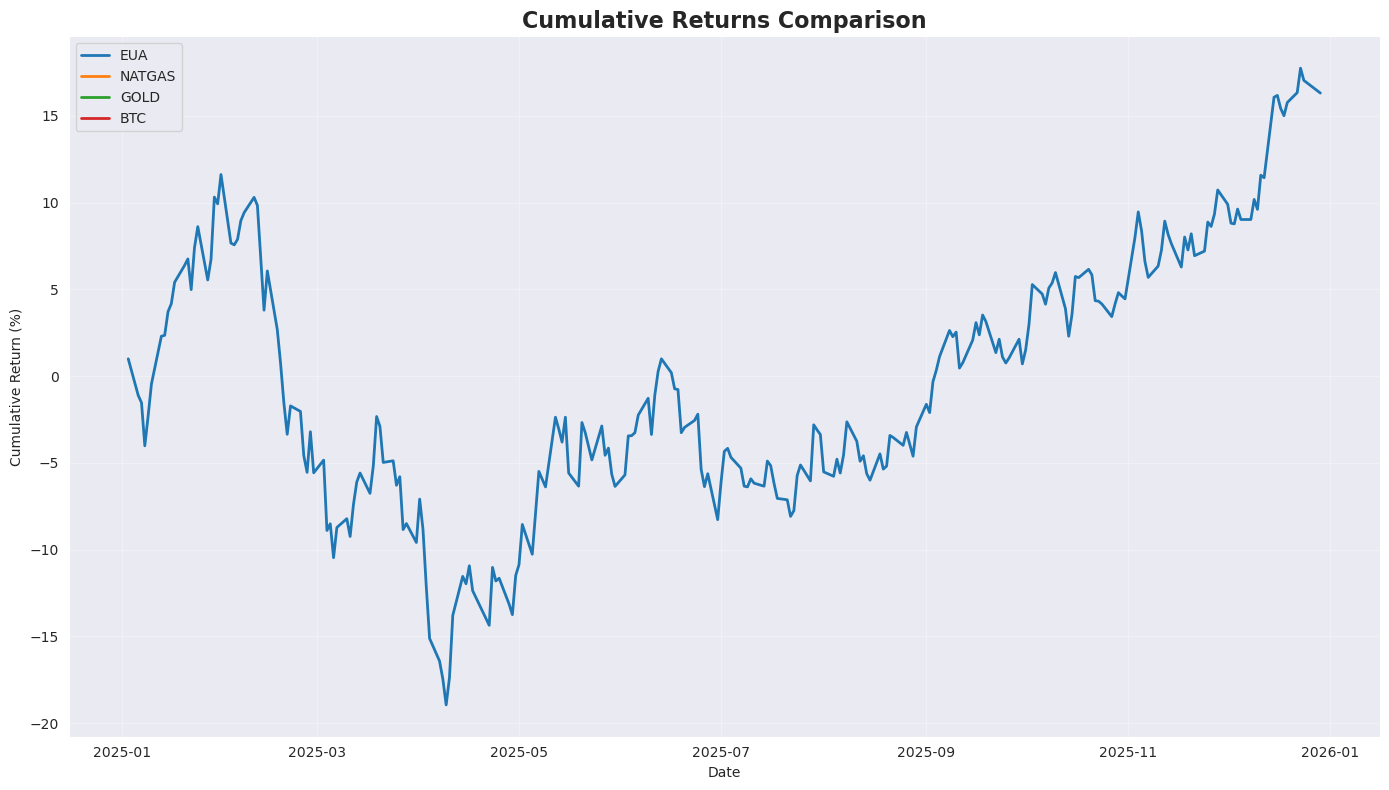

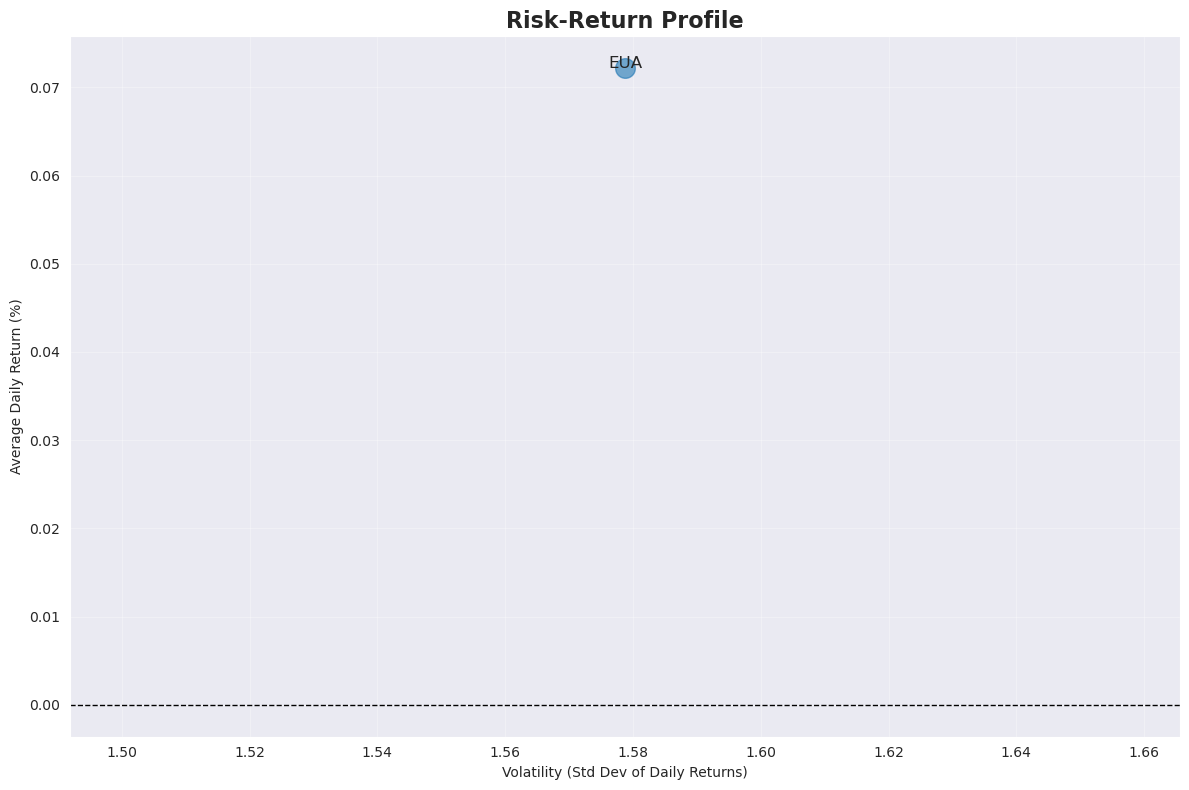

IndexError: single positional indexer is out-of-bounds

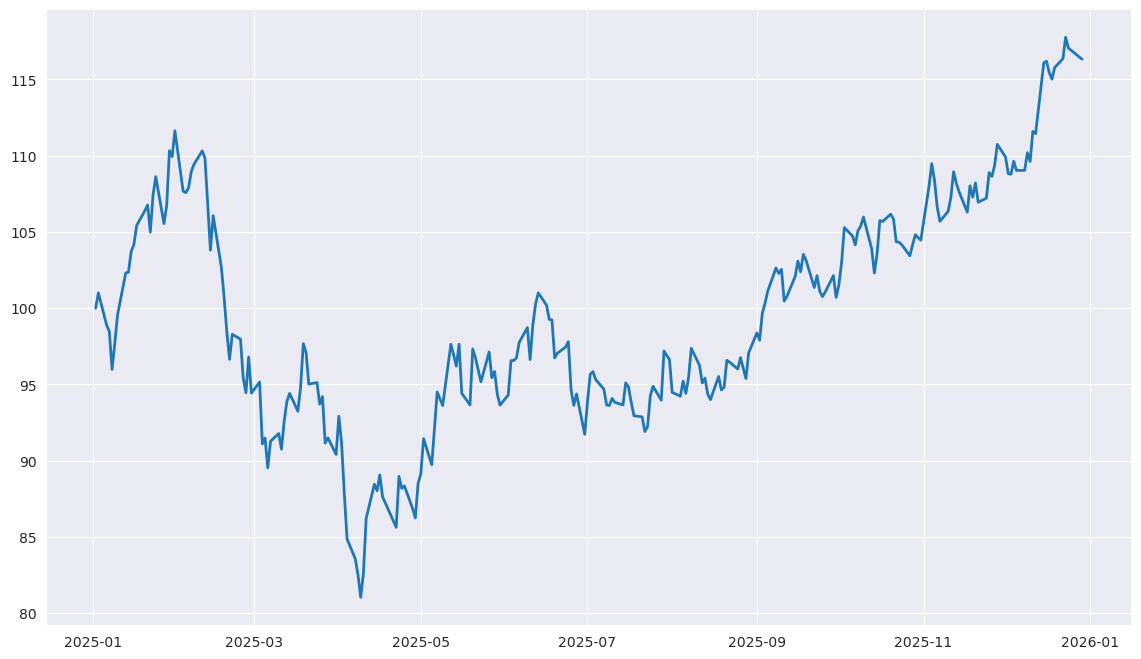

In [1]:
"""
Commodities Trading Dashboard - Data Collection & Analysis
Author: Your Name
Course: Python and SQL - Final Project

This notebook collects and analyzes data for:
- EUA (European Union Allowance)
- Natural Gas
- Gold
- Bitcoin
"""

# ============================================================================
# 1. IMPORT LIBRARIES
# ============================================================================
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import sqlite3
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 7)

# ============================================================================
# 2. DATA COLLECTION
# ============================================================================

def load_eua_data(filepath):
    """Load EUA data from CSV file"""
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df.columns = ['Date', 'Price', 'Open', 'High', 'Low', 'Vol', 'Change']
    df['Symbol'] = 'EUA'
    return df[['Date', 'Symbol', 'Open', 'High', 'Low', 'Price', 'Vol']]

def fetch_yfinance_data(ticker, start_date, end_date, symbol_name):
    """Fetch data from Yahoo Finance"""
    data = yf.download(ticker, start=start_date, end=end_date, progress=False)
    data = data.reset_index()
    data['Symbol'] = symbol_name
    data = data.rename(columns={'Close': 'Price', 'Volume': 'Vol'})
    return data[['Date', 'Symbol', 'Open', 'High', 'Low', 'Price', 'Vol']]

# Define date range
end_date = datetime.now()
start_date = end_date - timedelta(days=365*3)  # 3 years of data

# Load EUA data
print("Loading EUA data...")
eua_df = load_eua_data('/home/ondrej-marvan/Documents/GitHub/OBS_DataScience/OBS_DataScience/Autumn 2025/2400-DS1SQL Python and SQL intro, SQL platforms/Project/data/European Union Allowance (EUA) Yearly Futures Historical Data.csv')

# Fetch other commodities
print("Fetching Natural Gas data...")
natgas_df = fetch_yfinance_data('NG=F', start_date, end_date, 'NATGAS')

print("Fetching Gold data...")
gold_df = fetch_yfinance_data('GC=F', start_date, end_date, 'GOLD')

print("Fetching Bitcoin data...")
bitcoin_df = fetch_yfinance_data('BTC-USD', start_date, end_date, 'BTC')

# Combine all data
all_data = pd.concat([eua_df, natgas_df, gold_df, bitcoin_df], ignore_index=True)
print(f"\nTotal records collected: {len(all_data)}")

# ============================================================================
# 3. DATA CLEANING & PREPROCESSING
# ============================================================================

def clean_data(df):
    """Clean and preprocess the data"""
    # Remove duplicates
    df = df.drop_duplicates()
    
    # Handle missing values
    df = df.dropna(subset=['Open', 'High', 'Low', 'Price'])
    
    # Ensure proper data types
    df['Date'] = pd.to_datetime(df['Date'])
    numeric_cols = ['Open', 'High', 'Low', 'Price', 'Vol']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Sort by date
    df = df.sort_values(['Symbol', 'Date'])
    
    return df

all_data = clean_data(all_data)
print(f"After cleaning: {len(all_data)} records")

# ============================================================================
# 4. TECHNICAL INDICATORS CALCULATION
# ============================================================================

def calculate_sma(df, periods=[20, 50, 200]):
    """Calculate Simple Moving Averages"""
    for period in periods:
        df[f'SMA_{period}'] = df.groupby('Symbol')['Price'].transform(
            lambda x: x.rolling(window=period, min_periods=1).mean()
        )
    return df

def calculate_bollinger_bands(df, period=20, std_dev=2):
    """Calculate Bollinger Bands"""
    df['BB_Middle'] = df.groupby('Symbol')['Price'].transform(
        lambda x: x.rolling(window=period, min_periods=1).mean()
    )
    df['BB_Std'] = df.groupby('Symbol')['Price'].transform(
        lambda x: x.rolling(window=period, min_periods=1).std()
    )
    df['BB_Upper'] = df['BB_Middle'] + (std_dev * df['BB_Std'])
    df['BB_Lower'] = df['BB_Middle'] - (std_dev * df['BB_Std'])
    return df

def calculate_rsi(df, period=14):
    """Calculate Relative Strength Index"""
    def rsi_calc(prices):
        deltas = prices.diff()
        gain = deltas.where(deltas > 0, 0).rolling(window=period, min_periods=1).mean()
        loss = -deltas.where(deltas < 0, 0).rolling(window=period, min_periods=1).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    
    df['RSI'] = df.groupby('Symbol')['Price'].transform(rsi_calc)
    return df

def calculate_daily_returns(df):
    """Calculate daily returns"""
    df['Daily_Return'] = df.groupby('Symbol')['Price'].pct_change() * 100
    return df

# Apply technical indicators
print("\nCalculating technical indicators...")
all_data = calculate_sma(all_data, [20, 50, 200])
all_data = calculate_bollinger_bands(all_data)
all_data = calculate_rsi(all_data)
all_data = calculate_daily_returns(all_data)

# ============================================================================
# 5. BACKWARDATION ANALYSIS
# ============================================================================

def calculate_contango_backwardation(df):
    """
    Calculate contango/backwardation indicator
    Positive = Contango (futures > spot)
    Negative = Backwardation (futures < spot)
    """
    # Using Close vs Open as proxy for futures curve
    df['Futures_Spread'] = ((df['Price'] - df['Open']) / df['Open']) * 100
    
    # 10-day rolling average of spread
    df['Spread_MA10'] = df.groupby('Symbol')['Futures_Spread'].transform(
        lambda x: x.rolling(window=10, min_periods=1).mean()
    )
    
    # Classify market structure
    df['Market_Structure'] = df['Spread_MA10'].apply(
        lambda x: 'Contango' if x > 0.5 else ('Backwardation' if x < -0.5 else 'Normal')
    )
    
    return df

all_data = calculate_contango_backwardation(all_data)

# ============================================================================
# 6. SAVE TO SQL DATABASE
# ============================================================================

def save_to_database(df, db_name='commodities_trading.db'):
    """Save data to SQLite database"""
    conn = sqlite3.connect(db_name)
    
    # Main prices table
    df.to_sql('prices', conn, if_exists='replace', index=False)
    
    # Create aggregated statistics table
    stats_df = df.groupby('Symbol').agg({
        'Price': ['mean', 'std', 'min', 'max'],
        'Vol': 'sum',
        'Daily_Return': ['mean', 'std']
    }).reset_index()
    stats_df.columns = ['Symbol', 'Avg_Price', 'Price_Std', 'Min_Price', 'Max_Price', 
                        'Total_Volume', 'Avg_Return', 'Return_Volatility']
    stats_df.to_sql('statistics', conn, if_exists='replace', index=False)
    
    # Create users table for login
    users_df = pd.DataFrame({
        'username': ['admin', 'trader1'],
        'password': ['admin123', 'trader123'],  # In production, use hashed passwords!
        'role': ['admin', 'trader']
    })
    users_df.to_sql('users', conn, if_exists='replace', index=False)
    
    # Create orders table
    conn.execute('''
        CREATE TABLE IF NOT EXISTS orders (
            order_id INTEGER PRIMARY KEY AUTOINCREMENT,
            timestamp DATETIME DEFAULT CURRENT_TIMESTAMP,
            username TEXT,
            symbol TEXT,
            order_type TEXT,
            quantity REAL,
            price REAL,
            total_value REAL,
            status TEXT DEFAULT 'Pending'
        )
    ''')
    
    conn.commit()
    conn.close()
    print(f"\nData saved to {db_name}")

save_to_database(all_data)

# ============================================================================
# 7. EXPLORATORY DATA ANALYSIS & VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# Summary statistics by commodity
print("\n1. SUMMARY STATISTICS BY COMMODITY:")
print(all_data.groupby('Symbol')[['Price', 'Vol', 'Daily_Return']].describe())

# Recent market structure
print("\n2. CURRENT MARKET STRUCTURE:")
recent_structure = all_data.groupby('Symbol').tail(1)[['Symbol', 'Market_Structure', 'Spread_MA10']]
print(recent_structure)

# Visualization 1: Price Trends
plt.figure(figsize=(16, 10))
for i, symbol in enumerate(['EUA', 'NATGAS', 'GOLD', 'BTC'], 1):
    plt.subplot(2, 2, i)
    data = all_data[all_data['Symbol'] == symbol].tail(365)
    plt.plot(data['Date'], data['Price'], label='Price', linewidth=2)
    plt.plot(data['Date'], data['SMA_20'], label='SMA 20', alpha=0.7)
    plt.plot(data['Date'], data['SMA_50'], label='SMA 50', alpha=0.7)
    plt.title(f'{symbol} Price Trend (Last Year)', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('price_trends.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 2: Bollinger Bands
plt.figure(figsize=(16, 10))
for i, symbol in enumerate(['EUA', 'NATGAS', 'GOLD', 'BTC'], 1):
    plt.subplot(2, 2, i)
    data = all_data[all_data['Symbol'] == symbol].tail(180)
    plt.plot(data['Date'], data['Price'], label='Price', linewidth=2, color='black')
    plt.plot(data['Date'], data['BB_Upper'], label='Upper Band', linestyle='--', alpha=0.7)
    plt.plot(data['Date'], data['BB_Middle'], label='Middle Band', alpha=0.7)
    plt.plot(data['Date'], data['BB_Lower'], label='Lower Band', linestyle='--', alpha=0.7)
    plt.fill_between(data['Date'], data['BB_Lower'], data['BB_Upper'], alpha=0.2)
    plt.title(f'{symbol} Bollinger Bands', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('bollinger_bands.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 3: RSI Comparison
plt.figure(figsize=(16, 10))
for i, symbol in enumerate(['EUA', 'NATGAS', 'GOLD', 'BTC'], 1):
    plt.subplot(2, 2, i)
    data = all_data[all_data['Symbol'] == symbol].tail(180)
    plt.plot(data['Date'], data['RSI'], linewidth=2)
    plt.axhline(y=70, color='r', linestyle='--', label='Overbought (70)')
    plt.axhline(y=30, color='g', linestyle='--', label='Oversold (30)')
    plt.fill_between(data['Date'], 30, 70, alpha=0.1)
    plt.title(f'{symbol} RSI (Relative Strength Index)', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.legend()
    plt.ylim(0, 100)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('rsi_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 4: Daily Returns Distribution
plt.figure(figsize=(16, 10))
for i, symbol in enumerate(['EUA', 'NATGAS', 'GOLD', 'BTC'], 1):
    plt.subplot(2, 2, i)
    data = all_data[all_data['Symbol'] == symbol]['Daily_Return'].dropna()
    plt.hist(data, bins=50, edgecolor='black', alpha=0.7)
    plt.axvline(data.mean(), color='r', linestyle='--', linewidth=2, label=f'Mean: {data.mean():.2f}%')
    plt.title(f'{symbol} Daily Returns Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Daily Return (%)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('returns_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 5: Correlation Heatmap
plt.figure(figsize=(10, 8))
pivot_data = all_data.pivot_table(values='Price', index='Date', columns='Symbol')
correlation = pivot_data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Price Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 6: Backwardation/Contango Analysis
plt.figure(figsize=(16, 10))
for i, symbol in enumerate(['EUA', 'NATGAS', 'GOLD', 'BTC'], 1):
    plt.subplot(2, 2, i)
    data = all_data[all_data['Symbol'] == symbol].tail(180)
    colors = data['Spread_MA10'].apply(lambda x: 'green' if x < 0 else 'red')
    plt.bar(data['Date'], data['Spread_MA10'], color=colors, alpha=0.6)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=2)
    plt.title(f'{symbol} Market Structure (Backwardation/Contango)', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Spread (%)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('market_structure.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 7: Volume Analysis
plt.figure(figsize=(16, 10))
for i, symbol in enumerate(['EUA', 'NATGAS', 'GOLD', 'BTC'], 1):
    plt.subplot(2, 2, i)
    data = all_data[all_data['Symbol'] == symbol].tail(180)
    plt.bar(data['Date'], data['Vol'], alpha=0.6)
    plt.title(f'{symbol} Trading Volume', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('volume_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 8: Cumulative Returns
plt.figure(figsize=(14, 8))
for symbol in ['EUA', 'NATGAS', 'GOLD', 'BTC']:
    data = all_data[all_data['Symbol'] == symbol].copy()
    data['Cumulative_Return'] = (1 + data['Daily_Return']/100).cumprod() - 1
    plt.plot(data['Date'], data['Cumulative_Return'] * 100, label=symbol, linewidth=2)
plt.title('Cumulative Returns Comparison', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('cumulative_returns.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 9: Risk-Return Scatter
plt.figure(figsize=(12, 8))
risk_return = all_data.groupby('Symbol').agg({
    'Daily_Return': ['mean', 'std']
}).reset_index()
risk_return.columns = ['Symbol', 'Avg_Return', 'Volatility']

for _, row in risk_return.iterrows():
    plt.scatter(row['Volatility'], row['Avg_Return'], s=200, alpha=0.6)
    plt.annotate(row['Symbol'], (row['Volatility'], row['Avg_Return']), 
                fontsize=12, ha='center')

plt.axhline(y=0, color='black', linestyle='--', linewidth=1)
plt.title('Risk-Return Profile', fontsize=16, fontweight='bold')
plt.xlabel('Volatility (Std Dev of Daily Returns)')
plt.ylabel('Average Daily Return (%)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('risk_return.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 10: Price Performance Comparison (Normalized)
plt.figure(figsize=(14, 8))
for symbol in ['EUA', 'NATGAS', 'GOLD', 'BTC']:
    data = all_data[all_data['Symbol'] == symbol].copy()
    data['Normalized_Price'] = (data['Price'] / data['Price'].iloc[0]) * 100
    plt.plot(data['Date'], data['Normalized_Price'], label=symbol, linewidth=2)
plt.title('Normalized Price Performance (Base = 100)', fontsize=16, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Normalized Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('normalized_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)
print(f"\nDatabase created: commodities_trading.db")
print(f"Total visualizations saved: 10 PNG files")
print(f"\nNext step: Run the Streamlit app using:")
print("streamlit run streamlit_app.py")